## Background and Context

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

This makes sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms,  become a key strategy in social media marketing.


## Data Description

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").


## Data Set

The dataset has the following columns:

* tweet_id                                                           
* airline_sentiment                                               
* airline_sentiment_confidence                               
* negativereason                                                   
* negativereason_confidence                                    
* airline                                                                    
* airline_sentiment_gold                                              
* name     
* negativereason_gold 
* retweet_count
* text
* tweet_coord
* tweet_created
* tweet_location 
* user_timezone

## Objective

Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry. Implement all the NLP techniques and build a model to do the proper sentiment classification. 

## **Importing the libraries**

In [1]:
import re
import numpy as np                                  
import pandas as pd                                 
import nltk                                         

nltk.download('stopwords')    
nltk.download('punkt')

from nltk.corpus import stopwords                   
from nltk.stem import PorterStemmer                
from nltk.tokenize import word_tokenize 

from sklearn.feature_extraction.text import CountVectorizer          
from sklearn.feature_extraction.text import TfidfVectorizer          

#!pip install vaderSentiment   
#!pip install textblob   
# install and import necessary libraries.

#!pip install contractions

import re, string, unicodedata                          
import contractions                                     
from bs4 import BeautifulSoup                           

import numpy as np                                      
import pandas as pd                                     
import nltk                                             
from nltk.corpus import stopwords                       
from nltk.tokenize import word_tokenize, sent_tokenize  
from nltk.stem.wordnet import WordNetLemmatizer         
import matplotlib.pyplot as plt   
from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier       
from sklearn.metrics import classification_report        
from sklearn.model_selection import cross_val_score      

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\appradha.ORADEV\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\appradha.ORADEV\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Loading data into pandas dataframe
tweetsdf = pd.read_csv("D:\course\Tweets.csv")

In [3]:
tweetsdf.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## **Exploratory Data Analysis (EDA)**

In [4]:
tweetsdf.shape               # print shape of data.

(14640, 15)

### Checking for null values

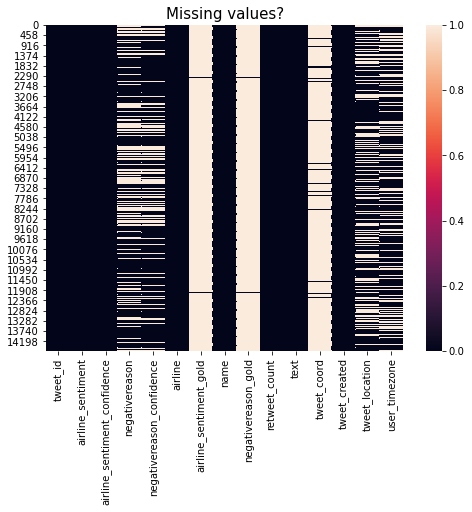

In [5]:
plt.figure(figsize=(8,6))
sns.heatmap(tweetsdf.isnull())                                  #Visualization of missing value using heatmap
plt.title("Missing values?", fontsize = 15)
plt.show()

- Based on the above plot, we can say as there are many of missing values in "tweet_coord" .
- "negativereason_gold" and "airlinesentiment_gold" columns have almost all missing values.
- There are some missing values in negative_reason, negativereason_confidence which is understandable since for postive reviews these columns will be null.
- User_timezone and tweet_location do have some missing values.

In [6]:
tweetsdf.isnull().sum(axis=0)          # Check for NULL values.

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

 * airline_sentiment_gold, negativereason_gold, tweet_coord  also have too many null values.

In [7]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)                                            # Nu of zero in each column
        mis_val = df.isnull().sum()                                                                #Missing value in each column
        mis_val_percent = 100 * df.isnull().sum() / len(df)                                        #Missing value percent accross column
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)                         #Concatenation of above aoutput
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})               #Renaming of each coumn
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']  #column having total of zero value and missing values
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df) # Column having percentage of totalof zero and missing value
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(                                                     #Selecting and sorting those column which have at not a zero value in % of Total Values column
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

missing_zero_values_table(tweetsdf)

Your selected dataframe has 15 columns and 14640 Rows.
There are 7 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
negativereason_gold,0,14608,99.8,14608,99.8,object
airline_sentiment_gold,0,14600,99.7,14600,99.7,object
tweet_coord,0,13621,93.0,13621,93.0,object
negativereason,0,5462,37.3,5462,37.3,object
user_timezone,0,4820,32.9,4820,32.9,object
tweet_location,0,4733,32.3,4733,32.3,object
negativereason_confidence,1344,4118,28.1,5462,37.3,float64


## Exploratory Data Analysis

### **Word Cloud for Negative Reviews**

In [60]:
from wordcloud import WordCloud,STOPWORDS

In [61]:
#creating word cloud for negative reviews
negative_reviews=tweetsdf[tweetsdf['airline_sentiment']=='negative']
words = ' '.join(negative_reviews['text'])
cleaned_word = " ".join([word for word in words.split()])

In [62]:
negwordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

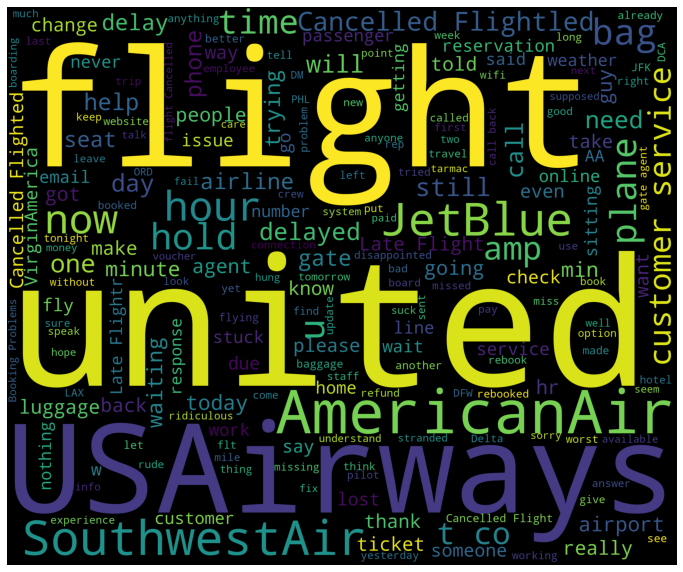

In [63]:
plt.figure(1,figsize=(12, 12))
plt.imshow(negwordcloud)
plt.axis('off')
plt.show()

* **Late Flight, Cancelled Flight, miss, suck, wait, worst, dissappointed ,problem, delay, rebooked, stuck , USA Airways, United, American Air** were some of the important recurring words observed in the negative reviews

### **Word Cloud for Positive Reviews**

In [14]:
#creating word cloud for negative reviews
positive_reviews=tweetsdf[tweetsdf['airline_sentiment']=='positive']
words = ' '.join(positive_reviews['text'])
cleaned_pos_word = " ".join([word for word in words.split()])

In [15]:
poswordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_pos_word)

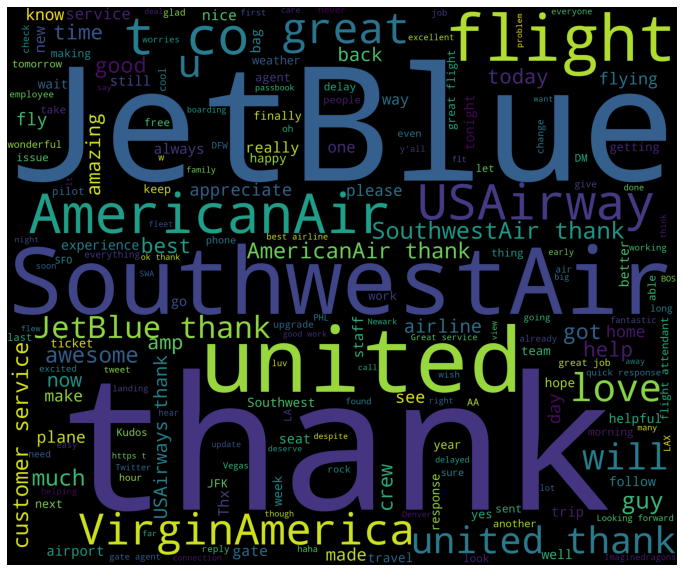

In [16]:
plt.figure(1,figsize=(12, 12))
plt.imshow(poswordcloud)
plt.axis('off')
plt.show()

* **Great service, thank, helpful, customer service, please, appreciate, best, amazing, nice, great, glad, awesome, kudos, best airline, better , really happy, excellent, good** were some of the important words observed in the positive reviews

In [5]:
tweetsdf['airline_sentiment'].unique()         #check the labels

array(['neutral', 'positive', 'negative'], dtype=object)

In [6]:
tweetsdf['airline_sentiment'].value_counts()     # check the count of each labels

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [7]:
tweetsdf['airline'].value_counts()  

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

### Distribution of sentiment across all tweets 

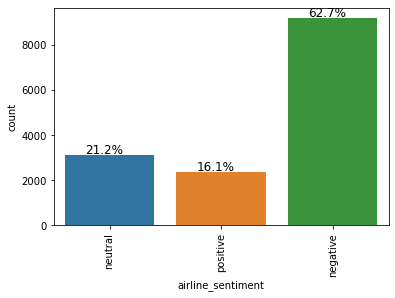

In [11]:
#plot the distribution of the class label
def bar_plot(data, feature):
    plot = sns.countplot(x =feature, data = data)
    total = len(data)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y),ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points")
    plt.xticks(rotation=90)
    plt.show()
    
bar_plot(tweetsdf,'airline_sentiment')

* Negative sentiments 62.7% are more in the data followed by neutral sentiments 21.2%. 
* Positive sentiments 16.1% are less than both other labels.

### Distribution of all tweets among each airline 

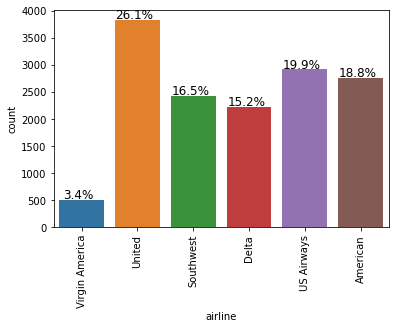

In [12]:
bar_plot(tweetsdf,'airline')

* 26% of all tweets are for United airlines, the maximum.
* Only 3.4% of all tweets are for virgin america, the minimum.
* The distribution os tweets for southwest, delta,US airways and American are roughly the same between 15-20%.

In [13]:
# function to plot stacked bar chart


def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 1, 5))
    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

### Distribution of sentiment all tweets amongst airlines

airline_sentiment  negative  neutral  positive    All
airline                                              
All                    9178     3099      2363  14640
Southwest              1186      664       570   2420
Delta                   955      723       544   2222
United                 2633      697       492   3822
American               1960      463       336   2759
US Airways             2263      381       269   2913
Virgin America          181      171       152    504
------------------------------------------------------------------------------------------------------------------------


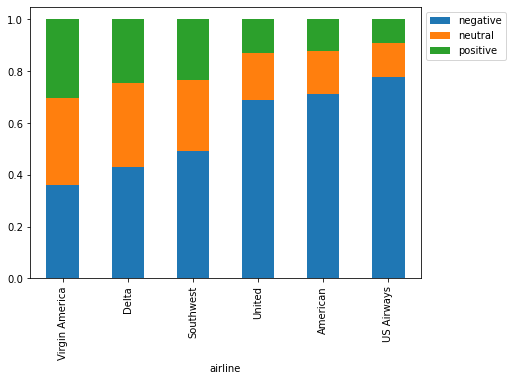

In [14]:
stacked_barplot(tweetsdf, "airline", "airline_sentiment")

* Negative sentiment is the maximum percentage almost 80% of total for US airways and positive sentiment the minimum.
* Positive sentiment is the maximum percentage of total for Virgin America and the distribution of all three sentiments almost 33%.

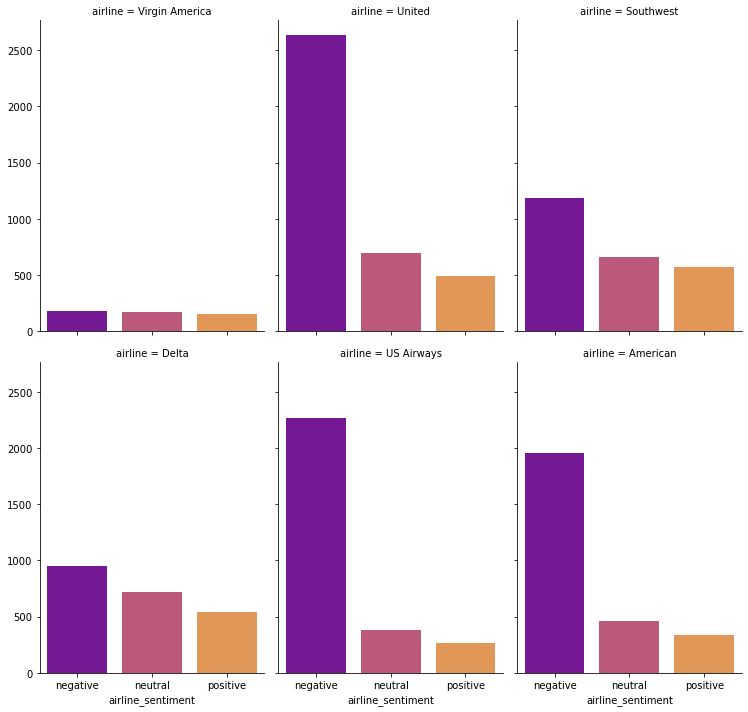

In [15]:
g = sns.FacetGrid(tweetsdf, col="airline", col_wrap=3, height=5, aspect =0.7)
g = g.map(sns.countplot, "airline_sentiment",order =tweetsdf.airline_sentiment.value_counts().index, palette='plasma')
plt.show()

### Distribution of negative reason

In [16]:
tweetsdf['negativereason'].value_counts() 

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

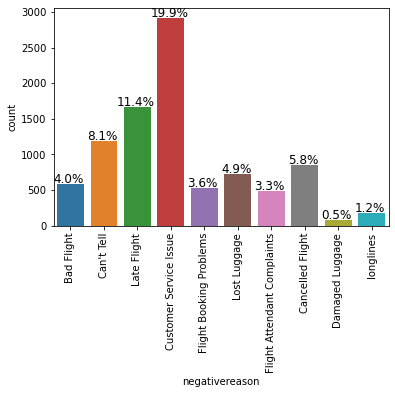

In [17]:
bar_plot(tweetsdf,'negativereason')

* Customer service issue is the most common negative reason in negative reviews consituting almost 20% of the distribution
* Damaged luggage is least common negative reason 0.5% in the negative reviews distribution
* Late flight constitues 11.4% of the negative reason distribution.
* Can't tell constitues 8.1% where no proper reason is cited.

* Dropping rest of the columns apart from airline_sentiment and text

In [8]:
tweetsdf.drop(columns=['tweet_id', 'airline_sentiment_confidence', 'negativereason', 'negativereason_confidence', 'airline_sentiment_gold', 'name', 'negativereason_gold', 'retweet_count', 'tweet_coord', 'tweet_created', 'tweet_location','airline','user_timezone'], inplace=True)

In [9]:
# Displaying the data shape
tweetsdf.shape

(14640, 2)

In [10]:
# Printing 5 data rows
pd.set_option('display.max_colwidth', None)
tweetsdf.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


## **Data Pre-processing**

- Remove html tags.
- Replace contractions in string. (e.g. replace I'm --> I am) and so on.
- Remove numbers.
- Tokenization.
- Removal of Special Characters and Punctuations.
- Conversion to lowercase.
- Remove Stopwords.
- Lemmatized or stemming data.
- Join the words in the list to convert back to text string in the data frame. (So that each row contains the data in text format.)

### Html tag removal, contractions removal, number removal

In [11]:
#remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

#expand the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

def clean_text(text):
    text = strip_html(text)
    text = replace_contractions(text)
    text = remove_numbers(text)
    return text
tweetsdf['text'] = tweetsdf['text'].apply(lambda x: clean_text(x))
tweetsdf.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials to the experience... tacky.
2,neutral,@VirginAmerica I did not today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it is a really big bad thing about it


### Tokentization

In [12]:
tweetsdf['text'] = tweetsdf.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
tweetsdf.head()

,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, have, added, commercials, to, the, experience, ..., tacky, .]"
2,neutral,"[@, VirginAmerica, I, did, not, today, ..., Must, mean, I, need, to, take, another, trip, !]"
3,negative,"[@, VirginAmerica, it, is, really, aggressive, to, blast, obnoxious, ``, entertainment, '', in, your, guests, ', faces, &, they, have, little, recourse]"
4,negative,"[@, VirginAmerica, and, it, is, a, really, big, bad, thing, about, it]"


### Stop word removal, lemmatization, punctuation mark removal, lowercase conversion, join words

In [13]:
stopwords = stopwords.words('english')
stopwords = list(set(stopwords)) 
lemmatizer = WordNetLemmatizer()

#remove the non-ASCII characters
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

# convert all characters to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# Remove the punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Remove the stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

#data['review'] = data['review'].astype(str)
tweetsdf['text'] = tweetsdf.apply(lambda row: normalize(row['text']), axis=1)

In [14]:
tweetsdf.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience tacky
2,neutral,virginamerica today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guests face little recourse
4,negative,virginamerica really big bad thing


## **Supervised Learning for Sentiment Analysis**

### **Bag of Words (CountVectorizer)**
      
In BoW, we construct a dictionary that contains the set of all unique words from our text review dataset. The frequency of the word is counted here. If there are **d** unique words in our dictionary then for every review the vector will be of length **d** and count of word from reviews is stored at its particular location in vector. The vector will be highly sparse in such cases.


In [15]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

Count_vec = CountVectorizer(max_features=500)                # Keep only 500 features as number of features will increase the processing time.
data_features = Count_vec.fit_transform(tweetsdf['text'])

data_features = data_features.toarray()                        # Convert the data features to array.

In [16]:
data_features.shape       #Shape of the feature vector

(14640, 500)

In [17]:
X = data_features

y = tweetsdf.airline_sentiment

In [18]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [58]:
crf = RandomForestClassifier(n_estimators = 10)
crf.fit(X_train, y_train)
crf.score(X_test, y_test)
count_vectorizer_predicted = crf.predict(X_test)
print(classification_report(y_test ,count_vectorizer_predicted , target_names = ['neutral' , 'positive','negative']))
print("Accuracy of the model is : ",accuracy_score(y_test,count_vectorizer_predicted))

              precision    recall  f1-score   support

     neutral       0.81      0.93      0.86      2627
    positive       0.51      0.23      0.31       577
    negative       0.66      0.55      0.60       456

    accuracy                           0.77      3660
   macro avg       0.66      0.57      0.59      3660
weighted avg       0.74      0.77      0.74      3660

Accuracy of the model is :  0.7718579234972678


### Tuning the model by finding the optimal estimators to increase accuracy

In [89]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(50,200,50).tolist()
base_ln

[50, 100, 150]

In [90]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

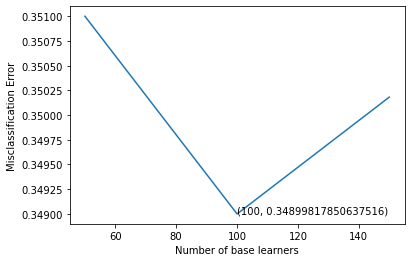

In [91]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [92]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
count_vectorizer_predicted = clf.predict(X_test)
print(classification_report(y_test ,count_vectorizer_predicted , target_names = ['neutral' , 'positive','negative']))
print("Accuracy of the model is : ",accuracy_score(y_test,count_vectorizer_predicted))

              precision    recall  f1-score   support

     neutral       0.81      0.94      0.87      2627
    positive       0.53      0.19      0.28       577
    negative       0.68      0.59      0.63       456

    accuracy                           0.78      3660
   macro avg       0.67      0.57      0.59      3660
weighted avg       0.75      0.78      0.75      3660

Accuracy of the model is :  0.7792349726775957


* **As can be seen the accuracy of the model is increased slightly after tuning it with optimum number of estimators**

[[2474   80   73]
 [ 416  111   50]
 [ 169   25  262]]


<AxesSubplot:>

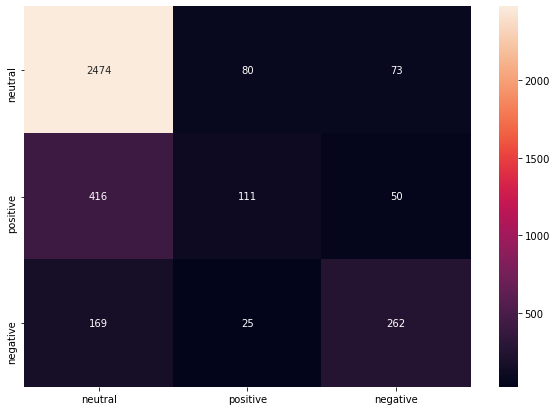

In [77]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, count_vectorizer_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['neutral', 'positive','negative']],
                  columns = [i for i in ['neutral', 'positive','negative']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

thank,jetblue,southwestair,unite,http,usairways,flight,great,delay,virginamerica,love,get,awesome,hold,amaze,fly,cancel,bag,hours,please,best,good,dm,make,would,help,wait,service,time,need,follow,go,tomorrow,hour,us,customer,know,airline,much,hi,
 
 


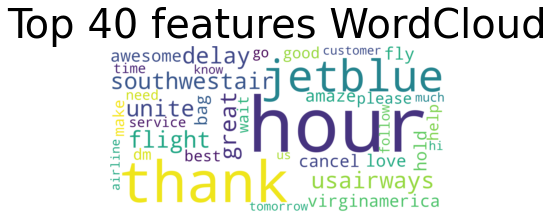

In [78]:
all_features = Count_vec.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=','
    
print(top_features)  

print(" ") 
print(" ")     

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=40)
plt.axis("off")
plt.show()

### **TF-IDF**

**Term Frequency -  Inverse Document Frequency:** It makes sure that less importance is given to the most frequent words, and it also considers less frequent words.

In [63]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_features=500)
data_features = tfidf_vect.fit_transform(tweetsdf['text'])

data_features = data_features.toarray()

data_features.shape     #feature shape

(14640, 500)

In [64]:
X = data_features

y = tweetsdf.airline_sentiment

In [65]:
# Split data into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [79]:
tfrf = RandomForestClassifier(n_estimators = 10)
tfrf.fit(X_train, y_train)
tfrf.score(X_test, y_test)
count_vectorizer_predicted = tfrf.predict(X_test)
print(classification_report(y_test ,count_vectorizer_predicted , target_names = ['neutral' , 'positive','negative']))
print("Accuracy of the model is : ",accuracy_score(y_test,count_vectorizer_predicted))

              precision    recall  f1-score   support

     neutral       0.81      0.93      0.87      2627
    positive       0.45      0.19      0.27       577
    negative       0.67      0.55      0.61       456

    accuracy                           0.77      3660
   macro avg       0.64      0.56      0.58      3660
weighted avg       0.73      0.77      0.74      3660

Accuracy of the model is :  0.7691256830601093


### Tuning the model with optimal estimators to increase the accuracy

In [66]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = np.arange(50,200,50).tolist()
base_ln

[50, 100, 150]

In [67]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

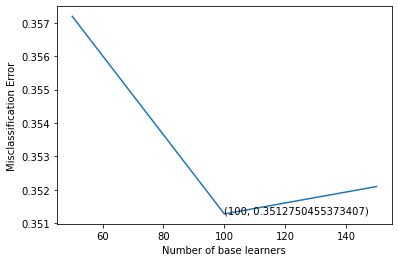

In [68]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [69]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
tf_idf_predicted = clf.predict(X_test)
print(classification_report(y_test , tf_idf_predicted , target_names =  ['neutral' , 'positive','negative']))
print("Accuracy of the model is : ",accuracy_score(y_test,tf_idf_predicted))

              precision    recall  f1-score   support

     neutral       0.81      0.95      0.87      2627
    positive       0.56      0.19      0.28       577
    negative       0.68      0.58      0.63       456

    accuracy                           0.78      3660
   macro avg       0.68      0.57      0.59      3660
weighted avg       0.75      0.78      0.75      3660

Accuracy of the model is :  0.7822404371584699


* **As can be seen by using optimal estimators the accuracy is improved to 78%**

[[2488   64   75]
 [ 419  109   49]
 [ 169   21  266]]


<AxesSubplot:>

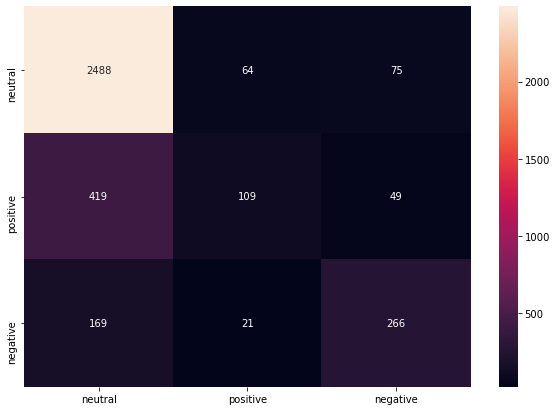

In [80]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, tf_idf_predicted)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['neutral', 'positive','negative']],
                  columns = [i for i in ['neutral', 'positive','negative']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

thank, jetblue, southwestair, unite, http, usairways, flight, great, delay, virginamerica, love, get, awesome, hold, amaze, fly, cancel, bag, hours, please, best, good, dm, make, would, help, wait, service, time, need, follow, go, tomorrow, hour, us, customer, know, airline, much, hi, 
 
 


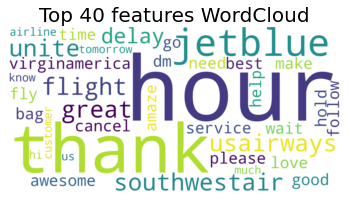

In [81]:
all_features = tfidf_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=', '
    
print(top_features)  

print(" ") 
print(" ") 

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

## **Comparing the accuracies of Supervised Learning methods i.e Count Vectorizer and TF-IDF**

In [82]:
#convert the test samples into a dataframe where the columns are
#the y_test(ground truth labels),tf-idf model predicted labels(tf_idf_predicted),Count Vectorizer model predicted labels(count_vectorizer_predicted)
df = pd.DataFrame(y_test.tolist(),columns =['y_test'])
df['count_vectorizer_predicted'] = count_vectorizer_predicted
df['tf_idf_predicted'] = tf_idf_predicted
df.head()

,y_test,count_vectorizer_predicted,tf_idf_predicted
0,negative,negative,negative
1,negative,negative,negative
2,negative,negative,negative
3,negative,negative,negative
4,positive,negative,negative


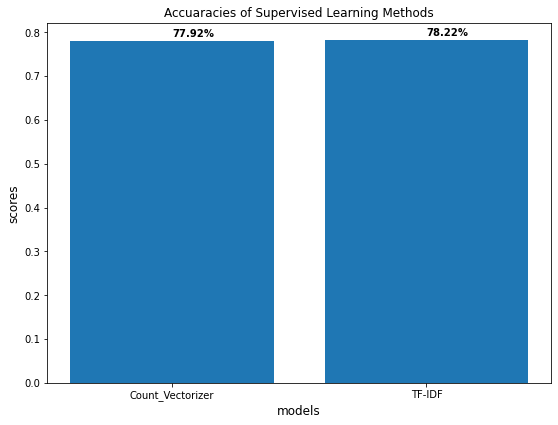

In [93]:
#create bar plot to compare the accuaracies of Count Vectorizer and TF-IDF
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
subjects = ['Count_Vectorizer', 'TF-IDF']

# calculation accuracies of Count Vectorizer and TF-IDF using accuracy_score metrics
scores = [accuracy_score(y_test,count_vectorizer_predicted),accuracy_score(y_test,tf_idf_predicted)]
ax.bar(subjects,scores)
ax.set_ylabel('scores',fontsize= 12)    # y axis label
ax.set_xlabel('models',fontsize= 12)    # x axis label
ax.set_title('Accuaracies of Supervised Learning Methods')  # tittle
for i, v in enumerate(scores):
    ax.text( i ,v+0.01, '{:.2f}%'.format(100*v), color='black', fontweight='bold')     
    plt.savefig('barplot_1.png',dpi=100, format='png', bbox_inches='tight')
plt.show()

* **TF-IDF shows a better performance than Count Vectorizer**, because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.

# **Conclusions**
#### The below are the main highlights of the sentiment analysis
- Exploratory Data Analysis.
- Text preprocessing methods.
- Working on Encoding text data using Count Vectorizer and TF-IDF and  classifying them using Machine learning models.
- Working on Unsupervised learning methods using Python packages for Sentiment Analysis like VADER sentiment analysis and TextBlob.
- Comparing the Machine learning models' performance with Sentiment Analysis using Python packages to check which one gave better and more accurate results.

### **Summary**:

- We used a dataset which has **sentiments related to various airlines in text format categorized as neutral, positive and negative.**
- The goal was to **build a model for text-classification**.
- We did **Exploratory Data Analysis** by plotting various plots like distribution of tweets among airlines, distribution of sentiments across all tweets, distribution of sentiment of tweets for each airline, distribution of all negative reasons.
- We created word clouds for top common words in positive and negative sentiments
- We **pre-processed the data** using various techniques and libraries.
    * Pre-procesing included :-
       a. Html tag removal.
       b. Tokenization.
       c. Remove the numbers.
       d. Removal of Special Characters and Punctuations.
       e. Removal of stopwords
       f. Conversion to lowercase.
       g. Lemmatize or stemming.
       h. Join the words in the list to convert back to text string in the data frame. (So that each row contains the data in text format.)
- We trained the model and optimized the parameter, which **led to an increase the overall accuracy.**
- After building the classification model, we **predicted the results for the test data.**
- We saw that using the above techniques, our model performed well in perspective of how text classification models perform.
- However, **we can still increase the accuracy of our model by increasing the dataset we took into account for the model building** 
- We can also increase the **max_feature parameter** in the vectorizer. 
- TF-IDF shows a better performance than Count Vectorizer, because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words. We can then remove the words that are less important for analysis, hence making the model building less complex by reducing the input dimensions.
- We can apply **other model tuning and hyperparameter tuning techniques, as well as other pre-processing techniques** to increase the overall accuracy even further.
 